# Define Train and Validate the models

This notebook takes the normalized csv files and uses TF with kernals to build a predictor for a virtul water level sensor.

In [1]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import os.path


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.13.0


In [3]:
# The current directory will be where this src file is located.
# Which is in the src dir of the project
dirpath = os.getcwd()
print("current directory is : " + dirpath)

current directory is : /Users/davis/progs/Keras-Philosophy/src


In [4]:
root_path = os.path.dirname(dirpath)
print("parent directory is : " + root_path)

parent directory is : /Users/davis/progs/Keras-Philosophy


In [5]:
data_path = root_path + "/data"
print("data_path is : " + data_path)

data_path is : /Users/davis/progs/Keras-Philosophy/data


In [6]:
logs_path = os.path.join(root_path,"logs")
print("logs directory is : " + logs_path)

logs directory is : /Users/davis/progs/Keras-Philosophy/logs


In [7]:
LOG_DIR_NAME = logs_path
os.environ['LOG_DIR_NAME'] = LOG_DIR_NAME

train_csv = data_path + "/train.csv"
test_csv = data_path + "/test.csv"
valid_csv = data_path + "/valid.csv"
os.environ['CSV_FILE_NAME'] = data_path + "/train.csv"

In [8]:
%%bash
echo ${LOG_DIR_NAME}

/Users/davis/progs/Keras-Philosophy/logs


In [9]:
%%bash
head ${CSV_FILE_NAME}

z,x,y
10.0,7.0,3.0
10.0,2.0,8.0
10.0,3.0,7.0
10.0,6.0,4.0
10.0,10.0,0.0
10.0,0.0,10.0
10.0,9.0,1.0
10.0,5.0,5.0


In [10]:
%%bash
# this csv file has 9875 lines corresponding to records (plus one header row)
wc -l ${CSV_FILE_NAME}

       9 /Users/davis/progs/Keras-Philosophy/data/train.csv


# Use generic python to read data into pandas dataframe

In [11]:
# Read the csv files into the new datasets
normed_train_ds = pd.read_csv(train_csv, 
                          header=0,
                          sep=",")

In [12]:
# Read the csv files into the new datasets
normed_valid_ds = pd.read_csv(valid_csv, 
                          header=0,
                          sep=",")

In [13]:
# Read the csv files into the new datasets
normed_test_ds = pd.read_csv(test_csv, 
                          header=0,
                          sep=",")

In [14]:
# Create seperate series/dataframe? for labels
# Remove the label from the dataframes.
train_labels = normed_train_ds.pop('z')
test_labels = normed_test_ds.pop('z')
valid_labels = normed_valid_ds.pop('z')

In [15]:
train_labels

0    10.0
1    10.0
2    10.0
3    10.0
4    10.0
5    10.0
6    10.0
7    10.0
Name: z, dtype: float64

In [16]:
normed_train_ds.keys()

Index(['x', 'y'], dtype='object')

# Build the model

In [17]:
# train_ds determines the input feature size


# Build a 2 layer 64 node DNN
#model = keras.Sequential([
#    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
#    layers.Dense(64, activation=tf.nn.relu),
#    layers.Dense(1)
#    ])

# Build a 3 layer 64, 16, 4 node DNN
model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
    ])



# Create a 1 layer 12 node DNN
#model = keras.Sequential([
#    layers.Dense(12, activation=tf.nn.relu, input_shape=[len(normed_train_ds.keys())]),
#    layers.Dense(1)
#    ])



# orig
#optimizer = tf.keras.optimizers.RMSprop(0.001)
# increase learning rate if fairly consistent but slow changing
#optimizer = tf.keras.optimizers.RMSprop(0.01)
# 0.1 is too big
#optimizer = tf.keras.optimizers.RMSprop(0.1)
# with the early stop, lets try to make the learning rate smaller
optimizer = tf.keras.optimizers.RMSprop(0.0001)

# Add in the early stop code
# The patience parameter is the amount of epochs to check for improvement
#
# NOTE: This was a good addition.  I'm so used to running through a lot of steps
# I did not realize that it was finding its best results so early.  In the 
# graphs that follows, you can see the divergent graphs here where the others
# did not show it since it was hundreds of epochs past optimal.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])


# Train the model (with three callbacks)

In [18]:
EPOCHS = 1000

In [19]:
%%bash
# clear any logs from previous runs
rm -rf ${LOG_DIR_NAME}

In [21]:
os.environ['LOG_DIR_NAME_TIME_VARIABLE'] = logdir

Wait a bit until the above pane shows the blank tensorboard page before running the cell below

In [22]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [23]:
#                    batch_size=16,

history = model.fit(normed_train_ds, 
                    train_labels,
                    epochs=EPOCHS,
                    validation_data = (normed_valid_ds, valid_labels),
                    verbose=0,
                    callbacks=[early_stop, tensorboard_callback, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................

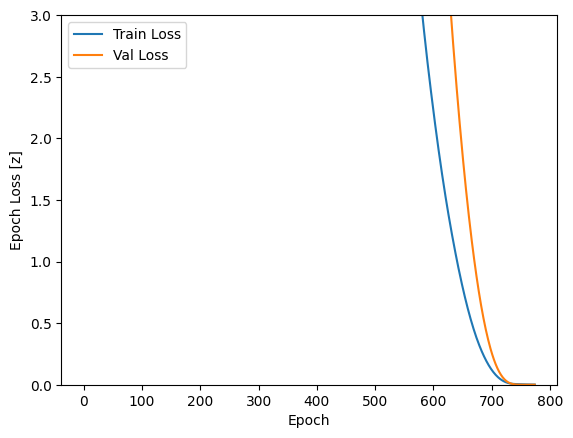

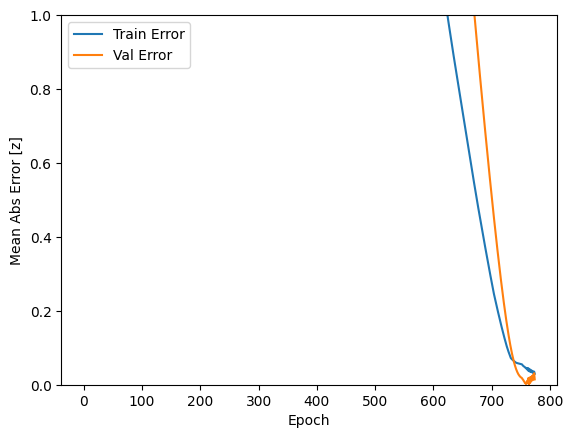

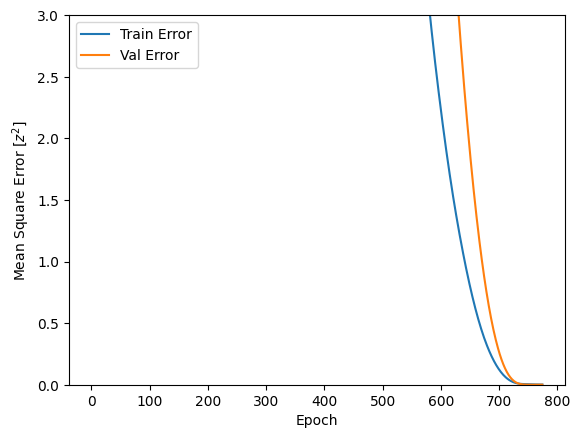

In [24]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Epoch Loss [z]')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.ylim([0,3])
    plt.legend()


    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [z]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$z^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [26]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,104.553452,10.216725,104.553452,118.023750,10.863873,118.023750,0
1,103.925102,10.185837,103.925102,117.648827,10.846604,117.648827,1
2,103.533737,10.166615,103.533737,117.348999,10.832774,117.348999,2
3,103.226456,10.151482,103.226456,117.082710,10.820477,117.082710,3
4,102.953926,10.138041,102.953926,116.837845,10.809155,116.837845,4
...,...,...,...,...,...,...,...
770,0.001627,0.033011,0.001627,0.000154,0.012391,0.000154,770
771,0.001570,0.036390,0.001570,0.000691,0.026295,0.000691,771
772,0.001538,0.031516,0.001538,0.000199,0.014116,0.000199,772
773,0.001514,0.035504,0.001514,0.000967,0.031094,0.000967,773


Now we are getting reasonable results.  Using a smaller learning rate, with an early stop callback.

# Evauate model
Note by including the data with missing values and adding in average amounts increased the error.

In [27]:
loss, mae, mse = model.evaluate(normed_test_ds, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} predicted xxt".format(mae))

Testing set Mean Abs Error:  0.05 predicted xxt


# Make predictions

1/1 [==============================] - 0s 41ms/step


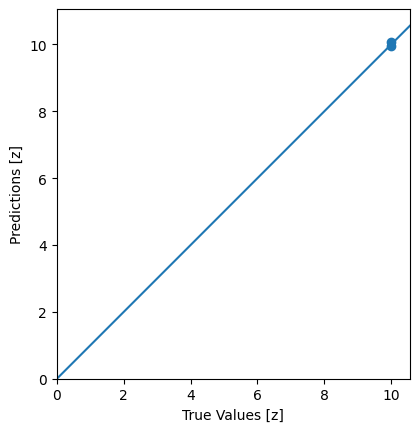

In [28]:
test_predictions = model.predict(normed_test_ds).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [z]')
plt.ylabel('Predictions [z]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Look at error distribution

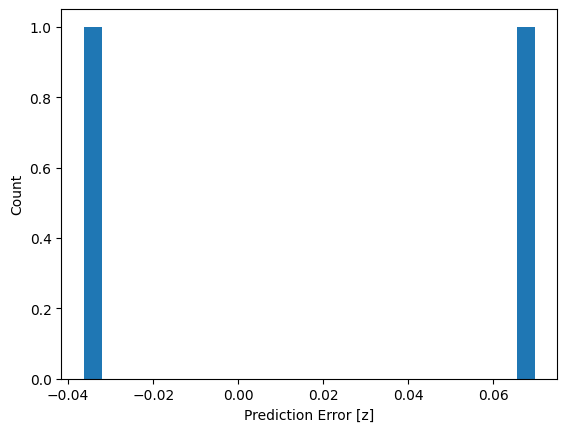

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [z]")
_ = plt.ylabel("Count")

In [30]:
normed_valid_ds


,x,y
0,1.0,9.0


In [31]:
model.predict(normed_valid_ds)

1/1 [==============================] - 0s 12ms/step


array([[10.014533]], dtype=float32)